In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.filters import threshold_otsu

import importlib
import sys

sys.path.append('C:\\Users\\marcu\\OneDrive\\Desktop\\PraktikumIII\\CapillaryRiseInSoil\\notebooks')

import amglib.imageutils as amg
import amglib.readers as rd
import amglib.bb as bb

import os

os.chdir('C:\\Users\\marcu\\OneDrive\\Desktop\\PraktikumIII\\CapillaryRiseInSoil')

import pandas as pd
import datetime 

from scipy.optimize import curve_fit

In [2]:
ts2 = rd.readImages('data/02_rawdata/Sand/4/4_{0:05d}.fits',first=1,last=29).astype(float)
timestamps=rd.read_fits_meta_data2('data/02_rawdata/Sand/4/4_{0:05d}.fits',first=1,last=29, parlist=['FRAME'])

  0%|          | 0/28 [00:00<?, ?it/s]

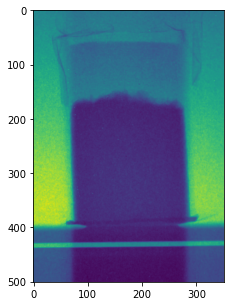

In [3]:
plt.figure(figsize=(7,5))
plt.imshow(ts2[13][::-1]) 
# plt.grid()

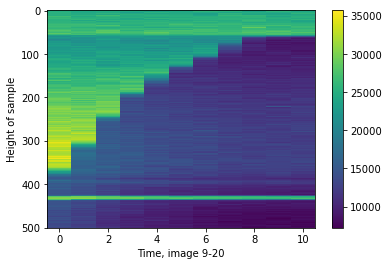

In [4]:
plt.imshow(ts2[9:20,::-1, 200].transpose(),aspect='auto', interpolation='none') # MM COMMENT -> Maybe 44:80??
plt.xlabel('Time, image 9-20')
plt.ylabel('Height of sample');
plt.colorbar()

In [5]:
tslice= ts2[9:20,::-1,200].transpose() # -> 44 to remove big black thinkg

In [6]:
np.mean(tslice) / np.std(tslice, ddof=1)

2.410047236249035

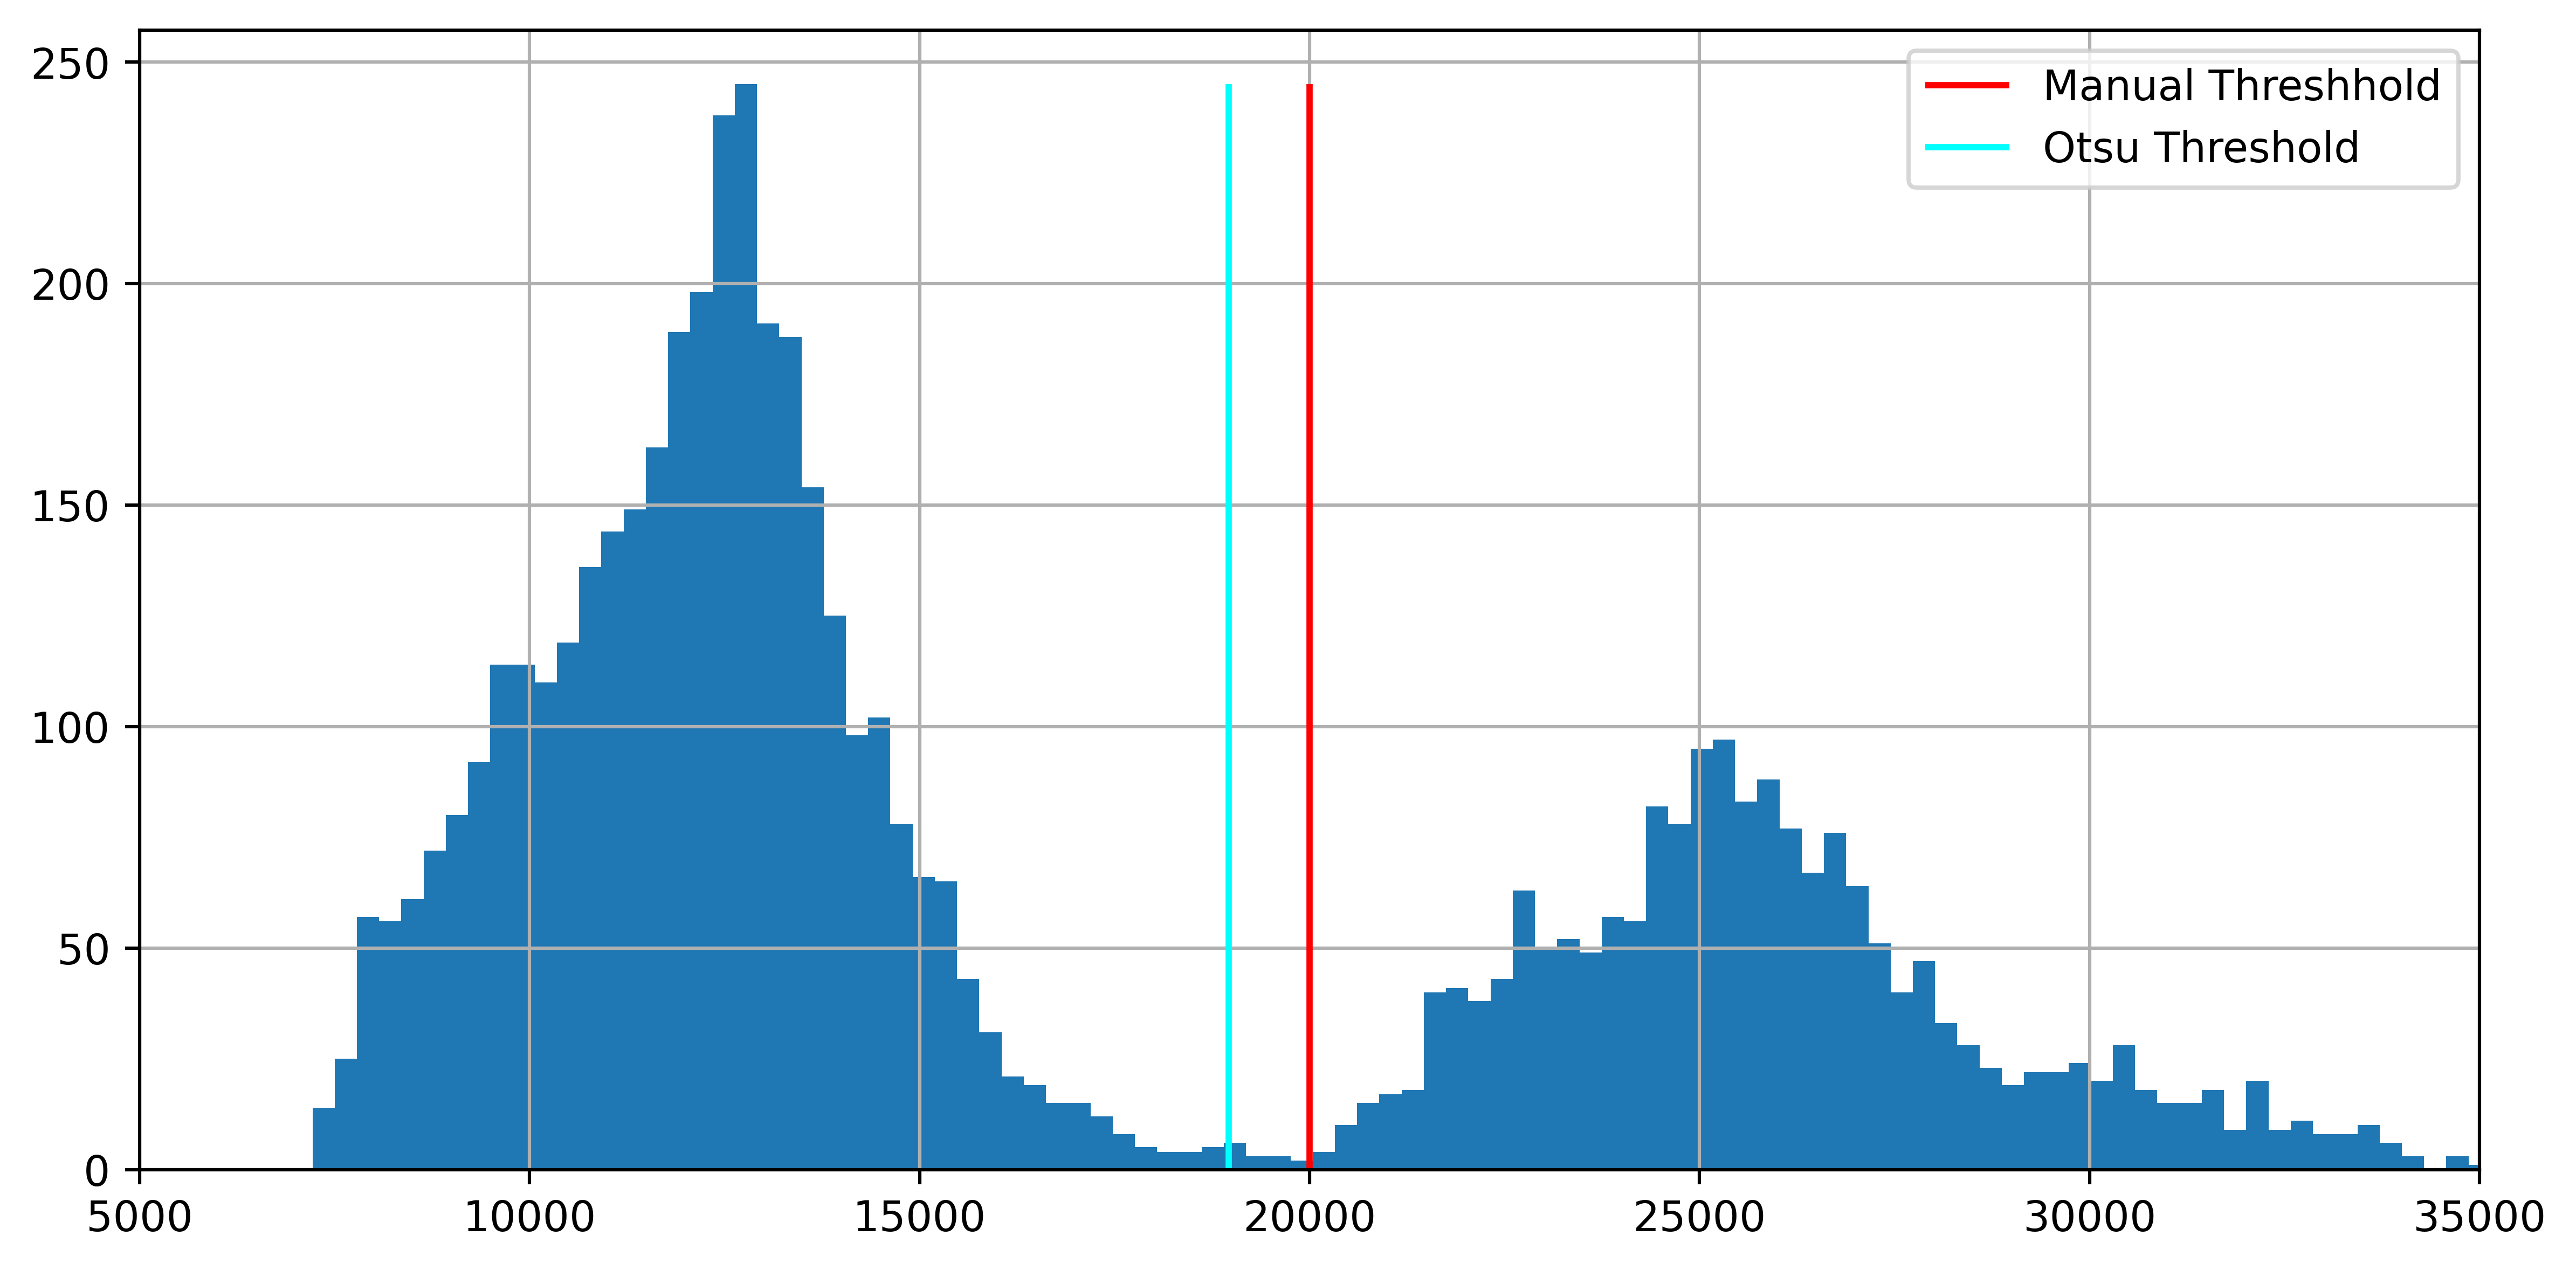

In [26]:
plt.figure(dpi=560, figsize=(10,5))
bin_fills = plt.hist(tslice.ravel(), bins=100)[0]
plt.vlines([20000],ymax=bin_fills.max(),ymin=0,color='red', label = "Manual Threshhold")
plt.vlines([threshold_otsu(tslice)],ymax=bin_fills.max(),ymin=0,color='cyan', label = "Otsu Threshold")
plt.grid()
plt.xlim(5000, 35000)
plt.legend()

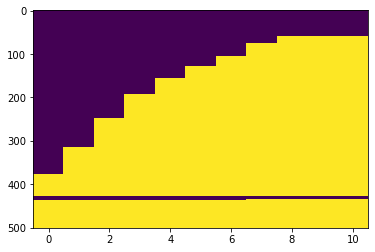

In [27]:
plt.imshow(tslice<20000,aspect='auto',interpolation='none')

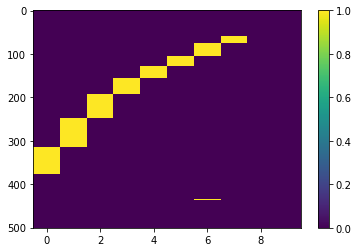

In [28]:
bts=tslice<20000
plt.imshow(bts[:,1:].astype(float)-bts[:,:-1].astype(float),aspect='auto',interpolation='none')
plt.colorbar()

In [29]:
dts=bts[:,1:].astype(float)-bts[:,:-1].astype(float)
points=np.where(0<dts)

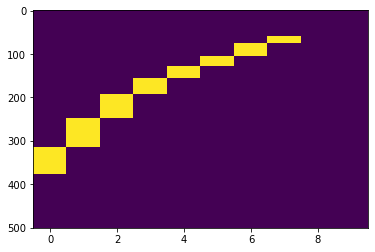

In [30]:
# remove outlier
dts[390:500, :] = 0
plt.imshow(dts, aspect='auto',interpolation='none')

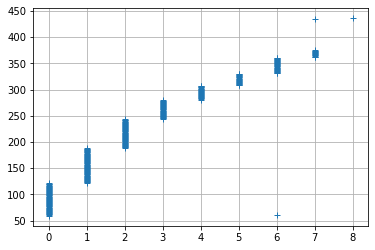

In [31]:
plt.plot(points[1], np.flip((points[0])),'+')
plt.grid()

In [32]:
cutoff = -9

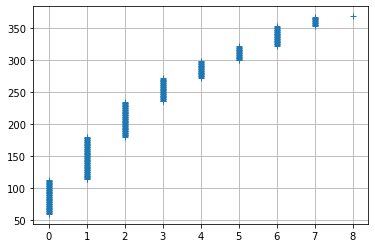

In [33]:
plt.plot(points[1][:cutoff], np.flip(points[0][:cutoff]),'+')
plt.grid()

##### T 

In [34]:
timestamps_s = np.zeros((len(timestamps['FRAME']), 2))
for i in range(len(timestamps['FRAME'])):
    s=timestamps['FRAME'][i][-2:]
    m=timestamps['FRAME'][i][-5:-3]
    timestamps_s[i] = (m, s)
time_array = timestamps_s[:,0] * 60 + timestamps_s[:,1];
time_array = pd.to_timedelta(time_array, unit='second');
time_array = time_array[9:20] 
time_delta_array = time_array[np.unique(points[1][:cutoff])] - time_array[0]
@np.vectorize
def convert_timedelta_to_second_int(val):
    return val.total_seconds()

subs = {k:v for v,k in zip(time_delta_array, np.unique(points[1][:cutoff]))}
new_time_array = np.array([subs.get(item,item) for item in points[1][:cutoff]])
new_time_array = convert_timedelta_to_second_int(new_time_array)

##### PX 

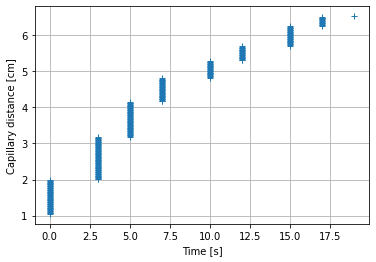

In [35]:
px_per_centimeter = 1578.0713/14 # px / cm
centimeter_per_pixel = px_per_centimeter**(-1)
cm_height = centimeter_per_pixel * np.flip(points[0][:cutoff]) * 2 # cm * px^-1 * px = cm, time 2 for binning
plt.figure()
plt.plot(new_time_array, cm_height, '+')
plt.xlabel("Time [s]")
plt.ylabel("Capillary distance [cm]")
# plt.xlim(-0.5,33.5)
plt.grid()

In [36]:
def srqt_analysis(t, a, b): # a = np.sqrt(c) c a collection of constants
    return a*np.sqrt(t)+b

height = cm_height # cm

time = new_time_array # s

popt, pcov = curve_fit(srqt_analysis, time, height, p0=[2.5, 0.1])

constants_sqrt, displacement = popt
new_model = lambda t: constants_sqrt * np.sqrt(t) + displacement   # cm = sqrt(...) * sqrt(time) -> constant has units m/time
time_linspace = np.linspace(0,20,100)

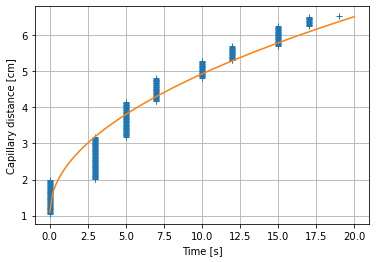

In [37]:
plt.figure()
plt.plot(new_time_array, cm_height, '+')
plt.plot(time_linspace, new_model(time_linspace))
plt.xlabel("Time [s]")
plt.ylabel("Capillary distance [cm]")
# plt.xlim(-0.5,33)
plt.grid()

In [20]:
cm_height.size

310

### Means 

In [52]:
points_new = ((points[0][:cutoff])[::-1], points[1][:cutoff])
means_std = np.zeros((len(np.unique(points_new[1])), 2))
maxima = np.zeros(len(np.unique(points_new[1])))

In [64]:
for (tmp, i) in enumerate(np.unique(points_new[1])):
    indices = np.where(points_new[1] == i)
    relevant_points = points_new[0][indices]
    means_std[tmp] = (relevant_points.mean(), relevant_points.std(ddof=1))
    maxima[tmp] = relevant_points.max()

means_std[:, 1][-1] = np.mean(means_std[:,1][:-1])
means_stdcm = np.array([means_std[:, 0] * centimeter_per_pixel * 2, means_std[:,1] * centimeter_per_pixel * 2])

maxima_w_error = np.array([maxima * centimeter_per_pixel * 2, maxima*centimeter_per_pixel*2/14])

C:\Users\marcu\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\marcu\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [65]:
means_stdcm

array([[1.51704172, 2.59050399, 3.67283785, 4.48902404, 5.05680573,
        5.50038519, 5.97945099, 6.38754409, 6.52948951],
       [0.27913803, 0.34572648, 0.28426026, 0.19205846, 0.14083211,
        0.12034009, 0.16132312, 0.0793499 , 0.20037856]])

In [66]:
maxima_w_error

array([[1.98723594, 3.17602887, 4.15190366, 4.80840124, 5.28746705,
        5.69556014, 6.24559866, 6.51174633, 6.52948951],
       [0.14194542, 0.2268592 , 0.29656455, 0.34345723, 0.37767622,
        0.40682572, 0.44611419, 0.46512474, 0.46639211]])

##### Real plots 

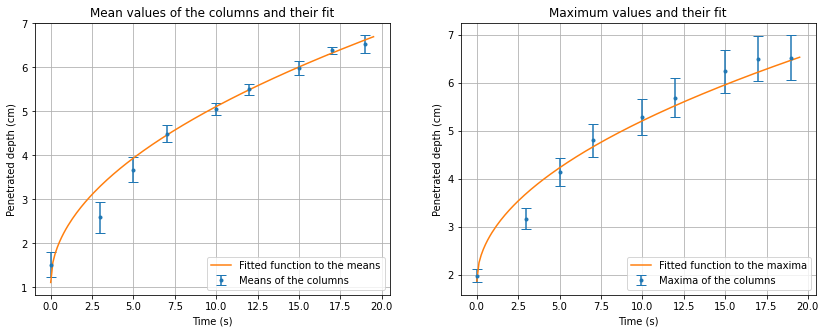

In [67]:
def sqrt_analysis(t, a, b): # a = np.sqrt(c) c a collection of constants
    return a*np.sqrt(t)+b

fig, ax = plt.subplots(1, 2, figsize=[14, 5])
ax = ax.ravel()

ax[0].set_title("Mean values of the columns and their fit")
ax[0].errorbar(np.unique(new_time_array), means_stdcm[0], yerr=means_stdcm[1], capsize=5, marker = '.', linestyle="", label="Means of the columns")

popt, pcov = curve_fit(sqrt_analysis, np.unique(new_time_array), means_stdcm[0], sigma = means_stdcm[1]) 
new_model = lambda x: popt[0] * np.sqrt(x) + popt[1] 
new_linsp = np.linspace(0, 19.5, 150)

ax[0].plot(new_linsp, new_model(new_linsp), label = "Fitted function to the means")
ax[0].legend(loc="lower right")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Penetrated depth (cm)")

ax[1].set_title("Maximum values and their fit")
ax[1].errorbar(np.unique(new_time_array), maxima_w_error[0], yerr=maxima_w_error[1], capsize=5, marker = '.', linestyle="", label="Maxima of the columns")

popt, pcov = curve_fit(sqrt_analysis, np.unique(new_time_array), maxima_w_error[0], sigma = maxima_w_error[1]) 
new_model = lambda x: popt[0] * np.sqrt(x) + popt[1] 
new_linsp = np.linspace(0, 19.5, 150)

ax[1].plot(new_linsp, new_model(new_linsp), label = "Fitted function to the maxima")
ax[1].legend(loc="lower right")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Penetrated depth (cm)")

for axis in ax:
    axis.grid()

In [68]:
np.unique(new_time_array)

array([ 0.,  3.,  5.,  7., 10., 12., 15., 17., 19.])

In [69]:
means_stdcm

array([[1.51704172, 2.59050399, 3.67283785, 4.48902404, 5.05680573,
        5.50038519, 5.97945099, 6.38754409, 6.52948951],
       [0.27913803, 0.34572648, 0.28426026, 0.19205846, 0.14083211,
        0.12034009, 0.16132312, 0.0793499 , 0.20037856]])

In [70]:
maxima_w_error

array([[1.98723594, 3.17602887, 4.15190366, 4.80840124, 5.28746705,
        5.69556014, 6.24559866, 6.51174633, 6.52948951],
       [0.14194542, 0.2268592 , 0.29656455, 0.34345723, 0.37767622,
        0.40682572, 0.44611419, 0.46512474, 0.46639211]])